# House Price Prediction

# Table of Contents
* 1.Background
* 2.Prepare the data
    * [2.1.Load data](#loaddata)
    * [2.2.Understand dataset](#understanddata)
* 3.Processing Data
    * 3.1. Clean Data
        <br>[Bar plot: Percentage of training missing value](#trainmissing)
        <br>[Bar plot: Percentage of testing missing value](#testmissing)
    * 3.2. Understand value of data
        <br>[Distribution plot and Probability plot: Sale price](#sale)
        <br>[Distribution plot and Probability plot: Ground Living Area](#gla)
        <br>[Distribution plot and Probability plot: Garage Area](#gaf)
* 4.Feature Engineering
    * [4.1 Pre-build Plot Function](#prebuilt)
    * [4.2.Feature Selection](#selection)
        <br>[Pearson correlation cofficient](#pearsonheatmap)
        <br>[Random Forest](#forest)
    * [4.3.Understand features](#relation)
        * Numerical Features vs Sale Price
        <br>[Pairplot: important features with sale price](#pairplot)
        <br>[Scatter plt: Ground Living Area vs Sale Price](#scattergla)
        <br>[Scatter plt: Ground living Area vs Sale price group by overall quality](#scattergla+)
        <br>[Scatter plt: Area features VS Sale Price](#area)
        <br>[Scatter plt: Groud Living Area VS Total rooms above grade](#glatagscatter)
        * Categorical Features vs Sale Price
        <br>[Box plt: Groud Living Area VS Total rooms above grade](#glatagbox)
        <br>[Box plt: Garage Car vs Garage Area](#garagecar)
        <br>[Box plt: Over all quality VS Sale Price](#overall)
        <br>[Box plt: Year Built VS Sale Price](#year)
        <br>[Scatter plt: Year Built VS Sale Price group by house style](#yearstyle)
        <br>[Box plt: MS Zooming vs Sale Price](#ms)
        <br>[Box plt: MS SubClass VS Sale Price](#msclass)
        <br>[Box plt: Neighbourhood vs Sale Price](#neighbourhood)
        

# 1. Background <a name=“background”></a>:
    Of course, every one wants to have their own dream house, but people need to consider  lots of conditions, like location of house, house quality, whethere any school near the neiborhood etc.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

## scipy
from scipy import stats

##xgboost
import xgboost
from xgboost import plot_importance

## matplotlib
import seaborn as sns; sns.set() # data visulization
import matplotlib.pyplot as plt # data visulization
%matplotlib inline

from collections import OrderedDict

## plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

## sklearn
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['sample_submission.csv', 'test.csv', 'data_description.txt', 'train.csv']


# 2. Prepare the data <a name="perpare">
## 2.1 Load data from csv <a name = "loaddata">

In [2]:
## read train.csv file into a pd dataframe named as df_train
df_train = pd.read_csv('../input/train.csv')
print('done')

done


In [3]:
## read test.csv file into a pd dataframe named as df_test
df_test = pd.read_csv('../input/test.csv')
print('done')

done


## 2.2 Understand Dataset<a name = "understanddata">

### 2.2.1 Take a look of all features

In [4]:
## print out all of the colums in df_train
df_train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [5]:
## print out all of the colums in df_test
df_test.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

### 2.2.2 Take a look of dataset size

In [6]:
## print out shape
print(df_train.drop_duplicates().shape)
print(df_test.drop_duplicates().shape)


(1460, 81)
(1459, 80)


### 2.2.3 Describe data

In [7]:
## describe df_train
df_train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [8]:
## print first 5 rows of df_train
df_train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [9]:
print(df_train.info)

<bound method DataFrame.info of         Id  MSSubClass MSZoning    ...     SaleType  SaleCondition SalePrice
0        1          60       RL    ...           WD         Normal    208500
1        2          20       RL    ...           WD         Normal    181500
2        3          60       RL    ...           WD         Normal    223500
3        4          70       RL    ...           WD        Abnorml    140000
4        5          60       RL    ...           WD         Normal    250000
5        6          50       RL    ...           WD         Normal    143000
6        7          20       RL    ...           WD         Normal    307000
7        8          60       RL    ...           WD         Normal    200000
8        9          50       RM    ...           WD        Abnorml    129900
9       10         190       RL    ...           WD         Normal    118000
10      11          20       RL    ...           WD         Normal    129500
11      12          60       RL    ...      

In [10]:
## describe df_test
df_test.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1459.000000,1459.000000,1232.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1444.000000,1458.000000,1458.000000,1458.000000,1458.000000,1459.000000,1459.000000,1459.000000,1459.000000,1457.000000,1457.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.00000,1381.000000,1458.000000,1458.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,2190.000000,57.378341,68.580357,9819.161069,6.078821,5.553804,1971.357779,1983.662783,100.709141,439.203704,52.619342,554.294925,1046.117970,1156.534613,325.967786,3.543523,1486.045922,0.434454,0.065202,1.570939,0.377656,2.854010,1.042495,6.385195,0.58122,1977.721217,1.766118,472.768861,93.174777,48.313914,24.243317,1.794380,17.064428,1.744345,58.167923,6.104181,2007.769705
std,421.321334,42.746880,22.376841,4955.517327,1.436812,1.113740,30.390071,21.130467,177.625900,455.268042,176.753926,437.260486,442.898624,398.165820,420.610226,44.043251,485.566099,0.530648,0.252468,0.555190,0.503017,0.829788,0.208472,1.508895,0.64742,26.431175,0.775945,217.048611,127.744882,68.883364,67.227765,20.207842,56.609763,30.491646,630.806978,2.722432,1.301740
min,1461.000000,20.000000,21.000000,1470.000000,1.000000,1.000000,1879.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,407.000000,0.000000,0.000000,407.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.00000,1895.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,1825.500000,20.000000,58.000000,7391.000000,5.000000,5.000000,1953.000000,1963.000000,0.000000,0.000000,0.000000,219.250000,784.000000,873.500000,0.000000,0.000000,1117.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.00000,1959.000000,1.000000,318.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,2190.000000,50.000000,67.000000,9399.000000,6.000000,5.000000,1973.000000,1992.000000,0.000000,350.500000,0.000000,460.000000,988.000000,1079.000000,0.000000,0.000000,1432.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,0.00000,1979.000000,2.000000,480.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,2554.500000,70.000000,80.000000,11517.500000,7.000000,6.000000,2001.000000,2004.000000,164.000000,753.500000,0.000000,797.750000,1305.000000,1382.500000,676.000000,0.000000,1721.000000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.00000,2002.000000,2.000000,576.000000,168.000000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,2919.000000,190.000000,200.000000,56600.000000,10.000000,9.000000,2010.000000,2010.000000,1290.000000,4010.000000,1526.000000,2140.000000,5095.000000,5095.000000,1862.000000,1064.000000,5095.000000,3.000000,2.000000,4.000000,2.000000,6.000000,2.000000,15.000000,4.00000,2207.000000,5.000000,1488.000000,1424.000000,742.000000,1012.000000,360.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


In [11]:
## print first 5 rows of df_test
df_test.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [12]:
print(df_test.info)

<bound method DataFrame.info of         Id  MSSubClass MSZoning      ...       YrSold  SaleType SaleCondition
0     1461          20       RH      ...         2010        WD        Normal
1     1462          20       RL      ...         2010        WD        Normal
2     1463          60       RL      ...         2010        WD        Normal
3     1464          60       RL      ...         2010        WD        Normal
4     1465         120       RL      ...         2010        WD        Normal
5     1466          60       RL      ...         2010        WD        Normal
6     1467          20       RL      ...         2010        WD        Normal
7     1468          60       RL      ...         2010        WD        Normal
8     1469          20       RL      ...         2010        WD        Normal
9     1470          20       RL      ...         2010        WD        Normal
10    1471         120       RH      ...         2010        WD        Normal
11    1472         160       RM 

# 3. Data processing<a name='dataprocess'>

## 3.1 Data clean<a name='dataclean'>
### 3.1.1 Drop 'ID'

In [13]:
df_train.drop('Id',axis=1,inplace=True)
df_test.drop('Id',axis=1,inplace=True)

### 3.1.2 Drop columns which percentage of missing value is greater than 15%

* Trainning Data

In [14]:
## count how many missing value which features have
missing_total = df_train.isnull().sum().sort_values(ascending = False)

## calculate percentage of missing data of each feature
percent = (missing_total / df_train.isnull().count()).sort_values(ascending = False)

## combine total numbers and percent into a dataframe
percent_missing_data = pd.concat([missing_total,percent],axis=1,keys=['Total','Percent'],sort=False)

## assign a continus numbers to dataframe as Index to order to plot text value from each features in barplot
Index = range(0,80)
percent_missing_data['Index'] = Index

## print first 20 rows of data
percent_missing_data.head(20)

,Total,Percent,Index
PoolQC,1453,0.995205,0
MiscFeature,1406,0.963014,1
Alley,1369,0.937671,2
Fence,1179,0.807534,3
FireplaceQu,690,0.472603,4
LotFrontage,259,0.177397,5
GarageType,81,0.055479,6
GarageCond,81,0.055479,7
GarageFinish,81,0.055479,8
GarageQual,81,0.055479,9


Barplot: Percentage of training missing value <a name = "trainmissing">

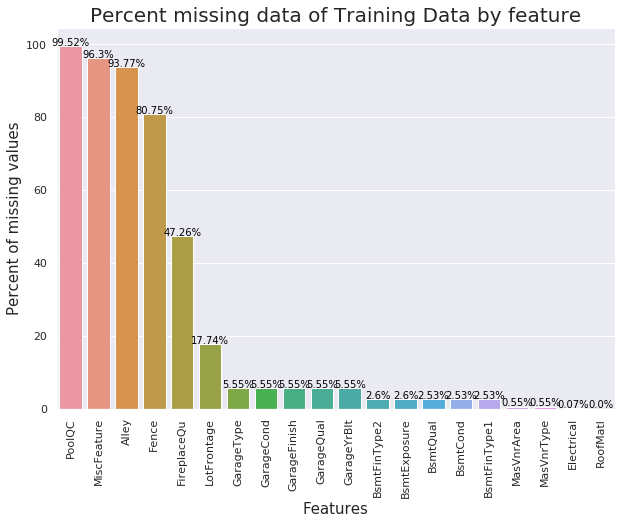

In [15]:
## print barplot showing percentage of each feature

## initilize figure size
f,ax = plt.subplots(figsize = (10,7))

## rotate X ticks in case X ticks overhead
plt.xticks(rotation='90')

## choose first 20 rows assigning to barplot
sns.barplot(x=percent_missing_data.index[:20], y=percent_missing_data.iloc[:20,1]*100)

## assign X,Y label 
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)

## assign plot title
plt.title('Percent missing data of Training Data by feature', fontsize=20)

## assign percentage value to each feature
for index, row in percent_missing_data.iloc[:20].iterrows():
    plt.text(int(row.Index),(row.Percent * 100) + 0.1,(np.around(row.Percent * 100,decimals=2)).astype(str) + "%",ha = "center",color = "black" )

## show plot
plt.show()

In [16]:
## drop feature which percentage of missing value > 15%
df_train_drop_useless = df_train.drop(percent_missing_data[percent_missing_data['Percent'] > 0.15].index,axis=1)

## check size of data after dropping
print(df_train_drop_useless.shape)

(1460, 74)


* Testing Data

In [17]:
## count how many missing value which features have
missing_total_test = df_test.isnull().sum().sort_values(ascending = False)

## calculate percentage of missing data of each feature
percent_test = (missing_total_test / df_test.isnull().count()).sort_values(ascending = False)

## combine total numbers and percent into a dataframe
percent_missing_data_test = pd.concat([missing_total_test,percent_test],axis=1,keys=['Total','Percent'],sort=False)

## assign a continus numbers to dataframe as Index to order to plot text value from each features in barplot
Index = range(0,79)
percent_missing_data_test['Index'] = Index

## print first 20 rows of data
percent_missing_data_test.head(25)

,Total,Percent,Index
PoolQC,1456,0.997944,0
MiscFeature,1408,0.965045,1
Alley,1352,0.926662,2
Fence,1169,0.801234,3
FireplaceQu,730,0.500343,4
LotFrontage,227,0.155586,5
GarageCond,78,0.053461,6
GarageFinish,78,0.053461,7
GarageYrBlt,78,0.053461,8
GarageQual,78,0.053461,9


Barplot: Percentage of testing missing value <a name = "testmissing">

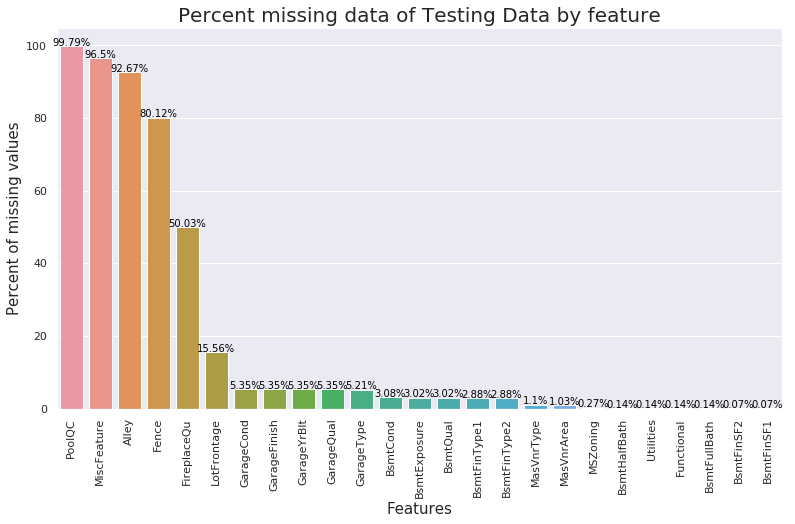

In [18]:
## print barplot showing percentage of each feature

## initilize figure size
f,ax = plt.subplots(figsize = (13,7))

## rotate X ticks in case X ticks overhead
plt.xticks(rotation='90')

## choose first 20 rows assigning to barplot
sns.barplot(x=percent_missing_data_test.index[:25], y=percent_missing_data_test.iloc[:25,1]*100)

## assign X,Y label 
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)

## assign plot title
plt.title('Percent missing data of Testing Data by feature', fontsize=20)

## assign percentage value to each feature
for index, row in percent_missing_data_test.iloc[:25].iterrows():
    plt.text(int(row.Index),(row.Percent * 100) + 0.1,(np.around(row.Percent * 100,decimals=2)).astype(str) + "%",ha = "center",color = "black" )

## show plot
plt.show()

In [19]:
## drop feature which percentage of missing value > 15%
df_test_drop_useless = df_test.drop(percent_missing_data_test[percent_missing_data_test['Percent'] > 0.15].index,axis=1)

## check size of data after dropping
print(df_test_drop_useless.shape)

(1459, 73)


### 3.1.3 Fill missing value

* **Dealing with training Data**

In [20]:
## figure out why GarageType is missing
df_train_missing_Garage = df_train[df_train['GarageCond'].isnull() == True]
df_train_missing_Garage

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
39,90,RL,65.0,6040,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,Duplex,1Story,4,5,1955,1955,Gable,CompShg,AsbShng,Plywood,None,0.0,TA,TA,PConc,NaN,NaN,NaN,NaN,0,NaN,0,0,0,GasA,TA,N,FuseP,1152,0,0,1152,0,0,2,0,2,2,Fa,6,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,N,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2008,WD,AdjLand,82000
48,190,RM,33.0,4456,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,2fmCon,2Story,4,5,1920,2008,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,736,736,GasA,Gd,Y,SBrkr,736,716,0,1452,0,0,2,0,2,3,TA,8,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,N,0,0,102,0,0,0,NaN,NaN,NaN,0,6,2009,New,Partial,113000
78,90,RL,72.0,10778,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,Duplex,1Story,4,5,1968,1968,Hip,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0,Unf,0,1768,1768,GasA,TA,N,SBrkr,1768,0,0,1768,0,0,2,0,4,2,TA,8,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,136500
88,50,C (all),105.0,8470,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,IDOTRR,Feedr,Feedr,1Fam,1.5Fin,3,2,1915,1982,Hip,CompShg,Plywood,Plywood,None,0.0,Fa,Fa,CBlock,TA,Fa,No,Unf,0,Unf,0,1013,1013,GasA,TA,N,SBrkr,1013,0,513,1526,0,0,1,0,2,1,Fa,6,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,N,0,0,156,0,0,0,NaN,MnPrv,NaN,0,10,2009,ConLD,Abnorml,85000
89,20,RL,60.0,8070,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,1Story,4,5,1994,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,588,Unf,0,402,990,GasA,Ex,Y,SBrkr,990,0,0,990,1,0,1,0,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,123600
99,20,RL,77.0,9320,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,4,5,1959,1959,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,569,Unf,0,381,950,GasA,Fa,Y,SBrkr,1225,0,0,1225,1,0,1,1,3,1,TA,6,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,Y,352,0,0,0,0,0,NaN,NaN,Shed,400,1,2010,WD,Normal,128950
108,50,RM,85.0,8500,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,IDOTRR,Artery,Norm,1Fam,1.5Fin,5,7,1919,2005,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0,Unf,0,793,793,GasW,TA,N,FuseF,997,520,0,1517,0,0,2,0,3,1,Fa,7,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,N,0,0,144,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,115000
125,190,RM,60.0,6780,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,2fmCon,1.5Fin,6,8,1935,1982,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,Fa,CBlock,TA,TA,Av,GLQ,490,Unf,0,30,520,GasA,Gd,N,SBrkr,520,0,234,754,1,0,1,0,2,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,N,53,0,0,0,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal,84500
127,45,RM,55.0,4388,Pave,NaN,IR1,Bnk,AllPub,Inside,Gtl,OldTown,Feedr,Norm,1Fam,1.5Unf,5,7,1930,1950,Gable,CompShg,WdShing,Wd Sdng,None,0.0,TA,Gd,BrkTil,TA,TA,No,LwQ,116,Unf,0,556,672,GasA,Ex,Y,SBrkr,840,0,0,840,0,0,1,0,3,1,TA,5,Typ,1,TA,NaN,NaN,NaN,0,0,NaN,NaN,N,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2007,WD,Normal,87000
140,20,RL,70.0,10500,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,NAmes,Norm,Norm,1Fam,1Story,4,5,1971,1971,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,432,Unf,0,432,864,GasA,TA,Y,SBrkr,864,0,0,864,0,0,1,0,3,1,TA,5,Typ,1,Po,NaN,NaN,NaN,0,0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,ConLI,No

In [21]:
df_train_missing_Garage[['GarageCond','GarageType','GarageQual','GarageFinish','GarageYrBlt']]

,GarageCond,GarageType,GarageQual,GarageFinish,GarageYrBlt
39,NaN,NaN,NaN,NaN,NaN
48,NaN,NaN,NaN,NaN,NaN
78,NaN,NaN,NaN,NaN,NaN
88,NaN,NaN,NaN,NaN,NaN
89,NaN,NaN,NaN,NaN,NaN
99,NaN,NaN,NaN,NaN,NaN
108,NaN,NaN,NaN,NaN,NaN
125,NaN,NaN,NaN,NaN,NaN
127,NaN,NaN,NaN,NaN,NaN
140,NaN,NaN,NaN,NaN,NaN


According to datafrme showing below, I find missing data comes when a house doesn't have any garage.  
* **GargeCond,GarageType,GarageQual and GarageFinish**: Replace missing data with None

In [22]:
for col in ('GarageCond','GarageType','GarageQual','GarageFinish'):
    df_train_drop_useless[col] = df_train_drop_useless[col].fillna('None')

*** **GarageYrBlt**: Replace missing data with 0

In [23]:
df_train_drop_useless['GarageYrBlt'] = df_train_drop_useless['GarageYrBlt'].fillna(0)

In [24]:
## figure out why Basement value is missing
df_train_missing_Basement = df_train[df_train['BsmtCond'].isnull() == True]

In [25]:
df_train_missing_Basement[['BsmtQual','BsmtCond','BsmtFinType1','BsmtFinType2','BsmtExposure']]

,BsmtQual,BsmtCond,BsmtFinType1,BsmtFinType2,BsmtExposure
17,NaN,NaN,NaN,NaN,NaN
39,NaN,NaN,NaN,NaN,NaN
90,NaN,NaN,NaN,NaN,NaN
102,NaN,NaN,NaN,NaN,NaN
156,NaN,NaN,NaN,NaN,NaN
182,NaN,NaN,NaN,NaN,NaN
259,NaN,NaN,NaN,NaN,NaN
342,NaN,NaN,NaN,NaN,NaN
362,NaN,NaN,NaN,NaN,NaN
371,NaN,NaN,NaN,NaN,NaN


According to the result showing below: I find the missing data comes when a house doesn't have a basement.
* **BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2**: Replace missing data with None

In [26]:
for col in ('BsmtQual','BsmtCond','BsmtFinType1','BsmtFinType2','BsmtExposure'):
    df_train_drop_useless[col] = df_train_drop_useless[col].fillna('None')

In [27]:
## figure out why Masonry veneer value is missing
df_train_missing_Masonry = df_train[df_train['MasVnrType'].isnull() == True]

In [28]:
df_train_missing_Masonry[['MasVnrType','MasVnrArea']]

,MasVnrType,MasVnrArea
234,NaN,NaN
529,NaN,NaN
650,NaN,NaN
936,NaN,NaN
973,NaN,NaN
977,NaN,NaN
1243,NaN,NaN
1278,NaN,NaN


According to the result showing below: I find the missing data comes when a house doesn't have any Masonry veneer.
* **MasVnrType**: Replace missing data with None

In [29]:
df_train_drop_useless['MasVnrType'] = df_train_drop_useless['MasVnrType'].fillna('None')

* **MasVnrArea**: Replace missing data with 0

In [30]:
df_train_drop_useless['MasVnrArea'] = df_train_drop_useless['MasVnrArea'].fillna(0)

In [31]:
## figure out why Electrical value is missing
df_train[df_train['Electrical'].isnull() == True]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1379,80,RL,73.0,9735,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,SLvl,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,384,384,GasA,Gd,Y,NaN,754,640,0,1394,0,0,2,1,3,1,Gd,7,Typ,0,NaN,BuiltIn,2007.0,Fin,2,400,TA,TA,Y,100,0,0,0,0,0,NaN,NaN,NaN,0,5,2008,WD,Normal,167500


In [32]:
## count value
df_train['Electrical'].value_counts()

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

* **Electrical**: Replace missing data with 'SBrkr', because this feature has mostly 'SBrkr'

In [33]:
df_train_drop_useless['Electrical'] = df_train_drop_useless['Electrical'].fillna('SBrkr')

In [34]:
## double check training dataset
df_train_drop_useless.isnull().sum().max()

0

* Dealing with testing data

In [35]:
## figure out why GarageType is missing
df_test_missing_Garage = df_test[df_test['GarageCond'].isnull() == True]

In [36]:
df_test_missing_Garage[['GarageCond','GarageType','GarageQual','GarageFinish','GarageYrBlt']]

,GarageCond,GarageType,GarageQual,GarageFinish,GarageYrBlt
53,NaN,NaN,NaN,NaN,NaN
71,NaN,NaN,NaN,NaN,NaN
79,NaN,NaN,NaN,NaN,NaN
92,NaN,NaN,NaN,NaN,NaN
96,NaN,NaN,NaN,NaN,NaN
98,NaN,NaN,NaN,NaN,NaN
100,NaN,NaN,NaN,NaN,NaN
130,NaN,NaN,NaN,NaN,NaN
133,NaN,NaN,NaN,NaN,NaN
134,NaN,NaN,NaN,NaN,NaN


According to datafrme showing below, I find missing data comes when a house doesn't have any garage.

* **GargeCond,GarageType,GarageQual and GarageFinish**: Replace missing data with None

In [37]:
for col in ('GarageCond','GarageType','GarageQual','GarageFinish'):
    df_test_drop_useless[col] = df_test_drop_useless[col].fillna('None')

* **GarageYrBlt**: Replace missing data with 0

In [38]:
df_test_drop_useless['GarageYrBlt'] = df_test_drop_useless['GarageYrBlt'].fillna(0)

In [39]:
## figure out why Basement value is missing
df_test_missing_Basement = df_test[df_test['BsmtCond'].isnull() == True]

In [40]:
df_test_missing_Basement[['BsmtQual','BsmtCond','BsmtFinType1','BsmtFinType2','BsmtExposure']]

,BsmtQual,BsmtCond,BsmtFinType1,BsmtFinType2,BsmtExposure
125,NaN,NaN,NaN,NaN,NaN
133,NaN,NaN,NaN,NaN,NaN
269,NaN,NaN,NaN,NaN,NaN
318,NaN,NaN,NaN,NaN,NaN
354,NaN,NaN,NaN,NaN,NaN
387,NaN,NaN,NaN,NaN,NaN
388,NaN,NaN,NaN,NaN,NaN
396,NaN,NaN,NaN,NaN,NaN
397,NaN,NaN,NaN,NaN,NaN
398,NaN,NaN,NaN,NaN,NaN


According to the result showing below: I find the missing data comes when a house doesn't have a basement.

* **BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2**: Replace missing data with None

In [41]:
for col in ('BsmtQual','BsmtCond','BsmtFinType1','BsmtFinType2','BsmtExposure'):
    df_test_drop_useless[col] = df_test_drop_useless[col].fillna('None')

* figure out why Masonry veneer value is missing

In [42]:
df_test_missing_Masonry = df_test[df_test['MasVnrType'].isnull() == True]

In [43]:
df_test_missing_Masonry[['MasVnrType','MasVnrArea']]

,MasVnrType,MasVnrArea
231,NaN,NaN
246,NaN,NaN
422,NaN,NaN
532,NaN,NaN
544,NaN,NaN
581,NaN,NaN
851,NaN,NaN
865,NaN,NaN
880,NaN,NaN
889,NaN,NaN


According to the result showing below: I find the missing data comes when a house doesn't have any Masonry veneer.

* **MasVnrType**: Replace missing data with None

In [44]:
df_test_drop_useless['MasVnrType'] = df_test_drop_useless['MasVnrType'].fillna('None')

* **MasVnrArea**: Replace missing data with 0

In [45]:
df_test_drop_useless['MasVnrArea'] = df_test_drop_useless['MasVnrArea'].fillna(0)

In [46]:
## figure out why MS Zoning value is missing
df_test[df_test['MSZoning'].isnull() == True]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
455,30,NaN,109.0,21780,Grvl,NaN,Reg,Lvl,NaN,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,2,4,1910,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,Fa,Fa,CBlock,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,GasA,TA,N,FuseA,810,0,0,810,0.0,0.0,1,0,1,1,TA,4,Min1,0,NaN,Detchd,1975.0,Unf,1.0,280.0,TA,TA,N,119,24,0,0,0,0,NaN,NaN,NaN,0,3,2009,ConLD,Normal
756,20,NaN,80.0,14584,Pave,NaN,Reg,Low,AllPub,Inside,Mod,IDOTRR,Norm,Norm,1Fam,1Story,1,5,1952,1952,Gable,CompShg,AsbShng,VinylSd,None,0.0,Fa,Po,Slab,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,Wall,Po,N,FuseA,733,0,0,733,0.0,0.0,1,0,2,1,Fa,4,NaN,0,NaN,Attchd,1952.0,Unf,2.0,487.0,Fa,Po,N,0,0,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Abnorml
790,70,NaN,NaN,56600,Pave,NaN,IR1,Low,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,2.5Unf,5,1,1900,1950,Hip,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0.0,Unf,0.0,686.0,686.0,GasA,Ex,Y,SBrkr,1150,686,0,1836,0.0,0.0,2,0,4,1,TA,7,Maj1,0,NaN,Detchd,1900.0,Unf,1.0,288.0,TA,Fa,N,0,0,0,0,0,0,NaN,NaN,NaN,0,1,2008,WD,Normal
1444,20,NaN,125.0,31250,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Artery,Norm,1Fam,1Story,1,3,1951,1951,Gable,CompShg,CBlock,VinylSd,None,0.0,TA,Fa,CBlock,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,GasA,TA,Y,FuseA,1600,0,0,1600,0.0,0.0,1,1,3,1,TA,6,Mod,0,NaN,Attchd,1951.0,Unf,1.0,270.0,Fa,TA,N,0,0,135,0,0,0,NaN,NaN,NaN,0,5,2006,WD,Normal


In [47]:
## count value
df_test['MSZoning'].value_counts()

RL         1114
RM          242
FV           74
C (all)      15
RH           10
Name: MSZoning, dtype: int64

* **MS Zoning**: Replace missing data with 'RL', because this feature has mostly 'RL'

In [48]:
df_test_drop_useless['MSZoning'] = df_test_drop_useless['MSZoning'].fillna('RL')

* Drop all of other missing data because there are only 1 or 2 in whole dataset considers as outlier.

In [49]:
df_test_drop = df_test_drop_useless.dropna()

In [50]:
## double check testing dataset
df_test_drop.isnull().sum().max()

0

### 3.1.4. Transform some numercial features into their real datatype

#MSSubClass=The building class
df_train_drop_useless['MSSubClass'] = df_train_drop_useless['MSSubClass'].apply(str)

#Changing OverallCond,OverallQual into a categorical variable
df_train_drop_useless['OverallCond'] = df_train_drop_useless['OverallCond'].astype(str)
df_train_drop_useless['OverallQual'] = df_train_drop_useless['OverallQual'].astype(str)

#Year and month sold are transformed into categorical features.
df_train_drop_useless['YrSold'] = df_train_drop_useless['YrSold'].astype(str)
df_train_drop_useless['MoSold'] = df_train_drop_useless['MoSold'].astype(str)
df_train_drop_useless['YearBuilt'] = df_train_drop_useless['YearBuilt'].astype(str)
df_train_drop_useless['YearRemodAdd'] = df_train_drop_useless['YearRemodAdd'].astype(str)
df_train_drop_useless['GarageYrBlt'] = df_train_drop_useless['GarageYrBlt'].astype(str)
df_train_drop_useless['GarageCars'] = df_train_drop_useless['GarageCars'].astype(str)

## 3.2 Beyond Analytics:Understanding value of the Data <a name = 'understandvalue'>

### 3.2.1. Understanding label(sale price)

In [51]:
## overview SalePrice
df_train_drop_useless['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Distribution plot and Probability plot <a name = 'sale'>

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



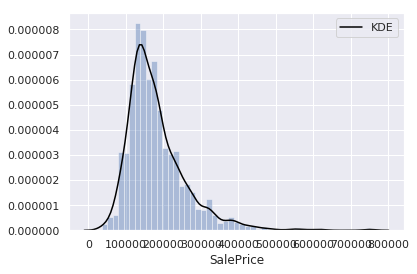

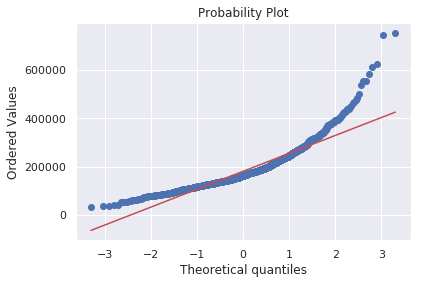

In [52]:
## plot distribution plot
sns.distplot(df_train_drop_useless['SalePrice'],kde_kws={"color":"black","label":"KDE"})

## plot probability plot
fig = plt.figure()
res = stats.probplot(df_train_drop_useless['SalePrice'],plot=plt)
plt.show()

In [53]:
#skewness and kurtosis
print("Skewness: %f" % df_train_drop_useless['SalePrice'].skew())
print("Kurtosis: %f" % df_train_drop_useless['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


* Normalize Sale Price

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



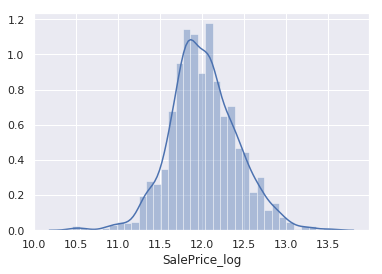

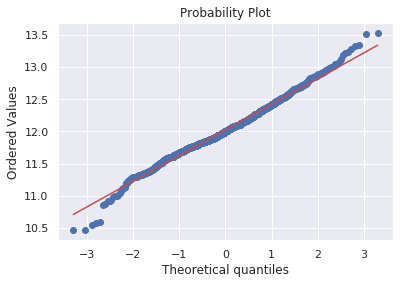

In [54]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
df_train_drop_useless["SalePrice_log"] = np.log1p(df_train_drop_useless["SalePrice"])

#Check the new distribution 
sns.distplot(df_train_drop_useless['SalePrice_log']);

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(df_train_drop_useless['SalePrice_log'], plot=plt)
plt.show()

In [55]:
#skewness and kurtosis
print("Skewness: %f" % df_train_drop_useless['SalePrice'].skew())
print("Kurtosis: %f" % df_train_drop_useless['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


### 3.2.2.Understanding numerical features

* Ground Living Area<a name = 'gla'>

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



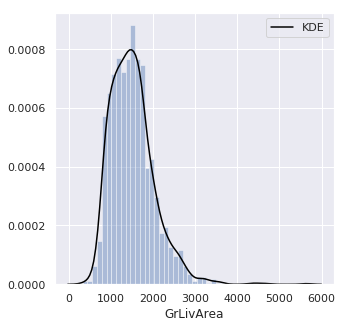

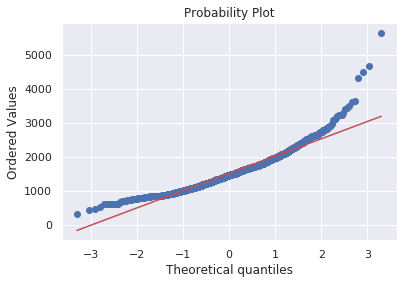

In [56]:
## plot Ground living area with dist plot 
f,ax = plt.subplots(figsize=(5,5))
sns.distplot(df_train_drop_useless['GrLivArea'],kde_kws={"color":"black","label":"KDE"})

## also plot probability plot
fig = plt.figure()
res =  stats.probplot(df_train_drop_useless['GrLivArea'],plot = plt)
plt.show()

In [57]:
#skewness and kurtosis
print("Skewness: %f" % df_train_drop_useless['GrLivArea'].skew())
print("Kurtosis: %f" % df_train_drop_useless['GrLivArea'].kurt())

Skewness: 1.366560
Kurtosis: 4.895121


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



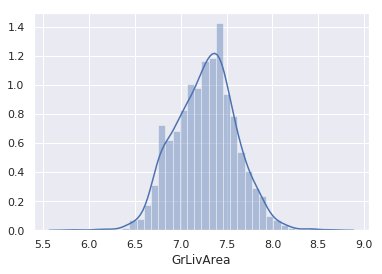

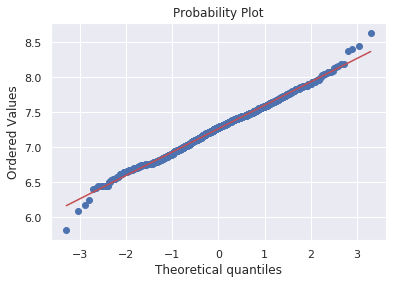

In [58]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
df_train_drop_useless["GrLivArea"] = np.log1p(df_train_drop_useless["GrLivArea"])

#Check the new distribution 
sns.distplot(df_train_drop_useless['GrLivArea']);

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(df_train_drop_useless['GrLivArea'], plot=plt)
plt.show()

* plot distribution dist plot of GarageArea feature<a name='gaf'>

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



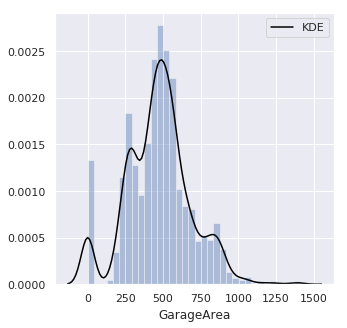

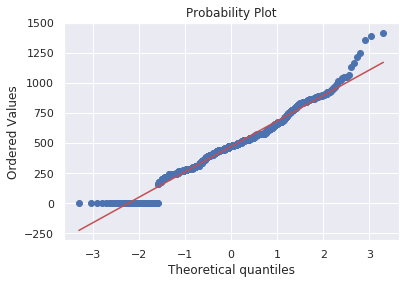

skewness: 0.17998090674623907
kurtosis: 0.9170672022708684


In [59]:
## plot GarageArea with dist plot 
f,ax = plt.subplots(figsize=(5,5))
sns.distplot(df_train_drop_useless['GarageArea'],kde_kws={"color":"black","label":"KDE"})

## also plot probability plot
fig = plt.figure()
res =  stats.probplot(df_train_drop_useless['GarageArea'],plot = plt)
plt.show()

print("skewness: {}".format(df_train_drop_useless['GarageArea'].skew()))
print("kurtosis: {}".format(df_train_drop_useless['GarageArea'].kurt()))


### 4. Feature engineering <a name = "engineering">
#### 4.1 Pre-built plot function<a name = 'prebuilt'>

* Box Plot from Plotly

In [93]:
def plotly_box_x_y(df,val_x,val_y):
    trace = []
    for name,group in df[[val_x,val_y]].groupby(val_x):
        trace.append(go.Box(y = group[val_y].values, 
                        boxpoints = 'all',
                        name = name))
    layout = go.Layout(
    title = val_x + ' vs ' + val_y,
    xaxis = dict(
        title = val_x,
        ticklen = 5),
    yaxis = dict(
        title = val_y,
        ticklen = 5))
    fig = go.Figure(data=trace,layout=layout)
    iplot(fig)
    

* Scatter Plot from Plotly

In [61]:
def plotly_scatter_x_y(df,val_x,val_y):
    fig = {'data': [{
        'x' : df[val_x],
        'y' : df[val_y],
        'mode' : 'markers'
    }],
          'layout' : {
              'title' : val_x + 'vs' + val_y,
              'xaxis' : {'title' : val_x},
              'yaxis' : {'title' : val_y}
          }}
    iplot(fig)
    

* Scatter Plot group by from Plotly

In [62]:
def plotly_scatter_x_y_catg_color(df, val_x, val_y, val_z):
    
    catg_for_colors = sorted(df[val_z].unique().tolist())

    fig = { 'data': [{ 'x': df[df[val_z]==catg][val_x],
                       'y': df[df[val_z]==catg][val_y],    
                       'name': catg, 
                       'text': df[val_z][df[val_z]==catg], 
                       'mode': 'markers',
                       'marker': {'size': 6},
                      
                     } for catg in catg_for_colors       ],
                       
            'layout': { 'xaxis': {'title': val_x},
                        'yaxis': {'title': val_y},                    
                        'colorway' : ['#a9a9a9', '#e6beff', '#911eb4', '#4363d8', '#42d4f4',
                                      '#3cb44b', '#bfef45', '#ffe119', '#f58231', '#e6194B'],
                        'autosize' : False, 
                        'width' : 750, 
                        'height' : 600,
                      }
           }
  
    iplot(fig)

#### 4.2 Feature selection <a name = "selection">

#### 4.2.1 Data filtering
* cut off by Pearson correlation coefficient

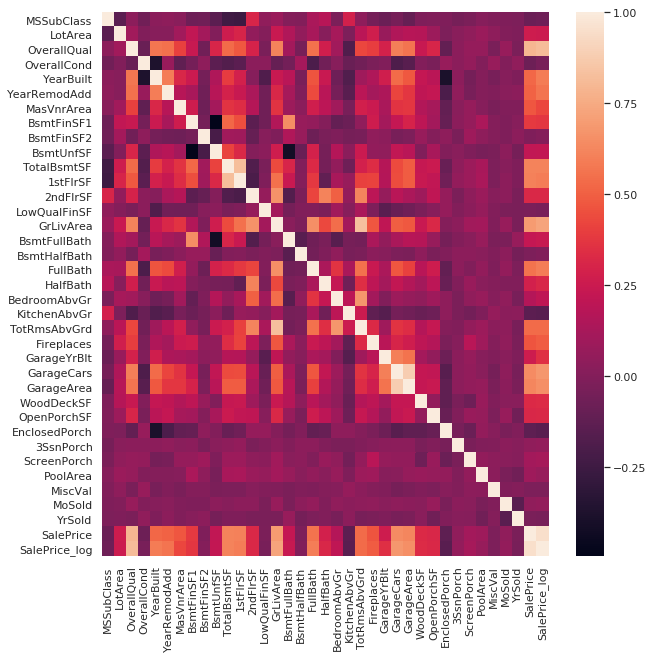

In [63]:
## show relationship among all of the feature by using heatmap
#correlation matrix
corrmat = df_train_drop_useless.corr()

f,ax = plt.subplots(figsize=(10,10))
sns.heatmap(corrmat)

Barplot: Pearson correlation<a name = 'barpearson'>

Text(0.5, 1.0, 'Pearson correlation coefficient')

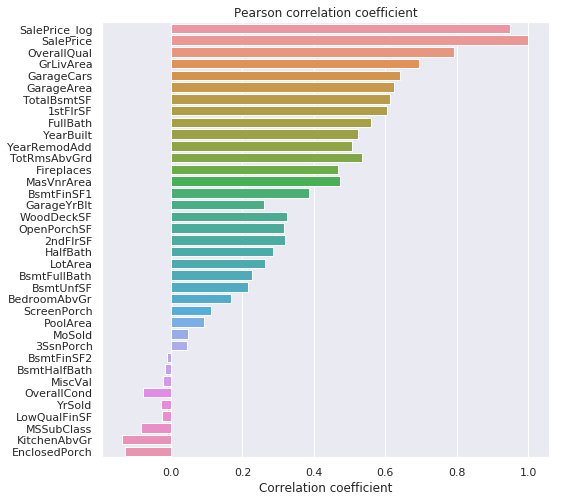

In [64]:
data = corrmat.sort_values(by=['SalePrice_log'],ascending=False)
x = data['SalePrice']
y = data.index
## bar plot showing more clear
f,ax = plt.subplots(figsize = (8,8))
sns.barplot(x,y)
sns.set_color_codes('pastel')
plt.xlabel('Correlation coefficient')
plt.title('Pearson correlation coefficient')

In [65]:
## compare corrlation value between sale price and all others feartures, figure out how many fearture moderate relationship with sale price(out put)
select_pos = corrmat['SalePrice_log'] >= 0.4  
select_nag = corrmat['SalePrice_log'] <= -0.4
select_pos = select_pos[select_pos == True]
print(select_pos.count()-1)
select_nag = select_nag[select_nag == True]
print(select_nag.count()-1)

13
-1


In [66]:
index = corrmat.nlargest(14,'SalePrice_log')['SalePrice_log'].index
index_drop = index.drop(['SalePrice'])
index_drop

Index(['SalePrice_log', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'FullBath', 'YearBuilt', 'YearRemodAdd',
       'TotRmsAbvGrd', 'Fireplaces', 'MasVnrArea'],
      dtype='object')

In [67]:
## show relationship among top 11 features by using heatmap
corr_after = df_train_drop_useless[index_drop].corr()
corr_after


,SalePrice_log,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,YearBuilt,YearRemodAdd,TotRmsAbvGrd,Fireplaces,MasVnrArea
SalePrice_log,1.000000,0.817185,0.730254,0.680625,0.650888,0.612134,0.596981,0.594771,0.586570,0.565608,0.534422,0.489450,0.426776
OverallQual,0.817185,1.000000,0.614207,0.600671,0.562022,0.537808,0.476224,0.550600,0.572323,0.550684,0.427452,0.396765,0.407252
GrLivArea,0.730254,0.614207,1.000000,0.496126,0.476164,0.435860,0.551440,0.653167,0.235500,0.311456,0.825521,0.468924,0.360905
GarageCars,0.680625,0.600671,0.496126,1.000000,0.882475,0.434585,0.439317,0.469672,0.537850,0.420622,0.362289,0.300789,0.361945
GarageArea,0.650888,0.562022,0.476164,0.882475,1.000000,0.486665,0.489782,0.405656,0.478954,0.371600,0.337822,0.269141,0.370884
TotalBsmtSF,0.612134,0.537808,0.435860,0.434585,0.486665,1.000000,0.819530,0.323722,0.391452,0.291066,0.285573,0.339519,0.360067
1stFlrSF,0.596981,0.476224,0.551440,0.439317,0.489782,0.819530,1.000000,0.380637,0.281986,0.240379,0.409516,0.410531,0.339850
FullBath,0.594771,0.550600,0.653167,0.469672,0.405656,0.323722,0.380637,1.000000,0.468271,0.439046,0.554784,0.243671,0.272999
YearBuilt,0.586570,0.572323,0.235500,0.537850,0.478954,0.391452,0.281986,0.468271,1.000000,0.592855,0.095589,0.147716,0.311600
YearRemodAdd,0.565608,0.550684,0.311456,0.420622,0.371600,0.291066,0.240379,0.439046,0.592855,1.000000,0.191740,0.112581,0.176529


* Pearson Correlation Heatmap<a name='pearsonheatmap'>

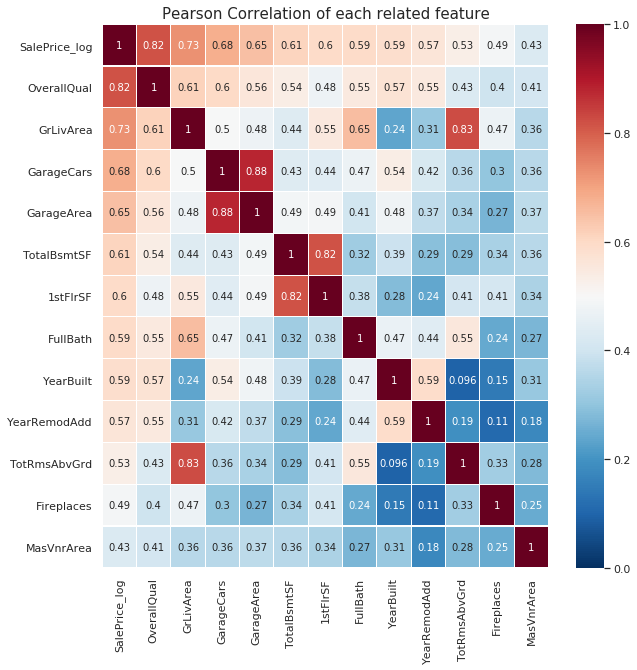

In [68]:
## plot heatmap
colormap = plt.cm.RdBu_r
f,ax = plt.subplots(figsize=(10,10))
plt.title('Pearson Correlation of each related feature',size = 15)
sns.heatmap(corr_after,linecolor='white',linewidths=0.1,cmap=colormap,annot=True,vmax=1.0,vmin=0)

#### 4.2.2 Data wrapping
* cut off by Random forest <a name ='forest'>

In [69]:
x = df_train_drop_useless.iloc[:,0:-1]
y = df_train_drop_useless.iloc[:,-1]

## one-hot encoding categorical features
x_dummies = pd.get_dummies(x)

In [70]:
rf = RandomForestRegressor()
rf.fit(x_dummies,y)
importance = rf.feature_importances_
indices = np.argsort(importance)[::-1]
features = x_dummies.columns
for f in range(0,30):
 print(("%2d) %-*s %f" % (f + 1, 30, features[f], importance[indices[f]])))

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



 1) MSSubClass                     0.998818
 2) LotArea                        0.000290
 3) OverallQual                    0.000157
 4) OverallCond                    0.000083
 5) YearBuilt                      0.000065
 6) YearRemodAdd                   0.000056
 7) MasVnrArea                     0.000053
 8) BsmtFinSF1                     0.000048
 9) BsmtFinSF2                     0.000043
10) BsmtUnfSF                      0.000043
11) TotalBsmtSF                    0.000037
12) 1stFlrSF                       0.000026
13) 2ndFlrSF                       0.000019
14) LowQualFinSF                   0.000018
15) GrLivArea                      0.000017
16) BsmtFullBath                   0.000015
17) BsmtHalfBath                   0.000013
18) FullBath                       0.000013
19) HalfBath                       0.000010
20) BedroomAbvGr                   0.000010
21) KitchenAbvGr                   0.000010
22) TotRmsAbvGrd                   0.000009
23) Fireplaces                  

* cut off by xgboost regressor

model = xgboost.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=10000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42) 

every_column_except_y= [col for col in df_train_drop_useless.columns if col not in ['SalePrice','Id']]
model.fit(pd.get_dummies(df_train_drop_useless[every_column_except_y]),df_train_drop_useless['SalePrice'])

OrderedDict(sorted(model.booster().get_fscore().items(), key=lambda t: t[1], reverse=True))

#### 4.2.3 Feature extraction
* cut off by PCA (principal component analysis)

### 4.3 Understand relationship between features and house price<a name="relation">
#### 4.3.1 Take a quick look for big picture <a name ='pairplot'>

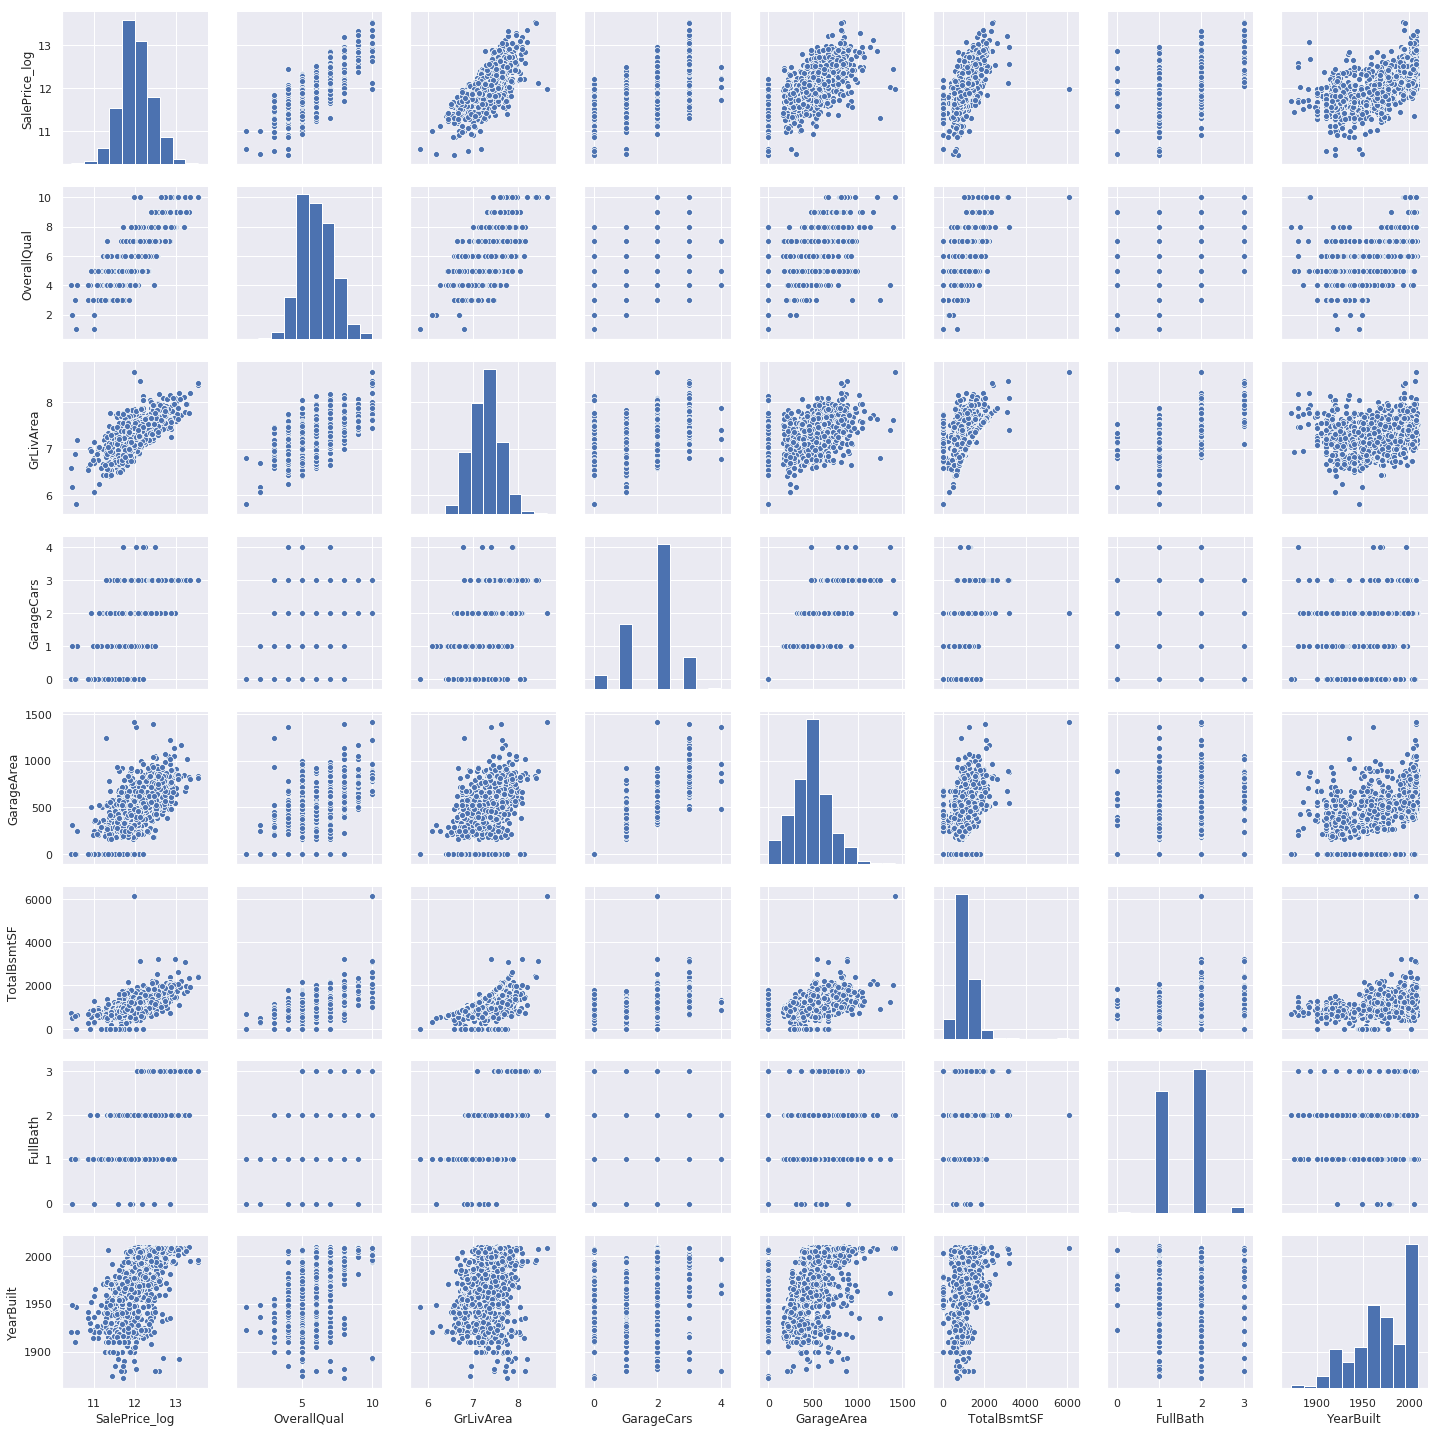

In [71]:
# scatterplot
cols = ['SalePrice_log', 'OverallQual', 'GrLivArea', 'GarageCars','GarageArea','TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(df_train_drop_useless[cols], height = 2.5)

#### 4.3.2 Understand relationship between some numerical features and house price

* Ground living Area vs Sale Price Log<a name= 'scattergla'>

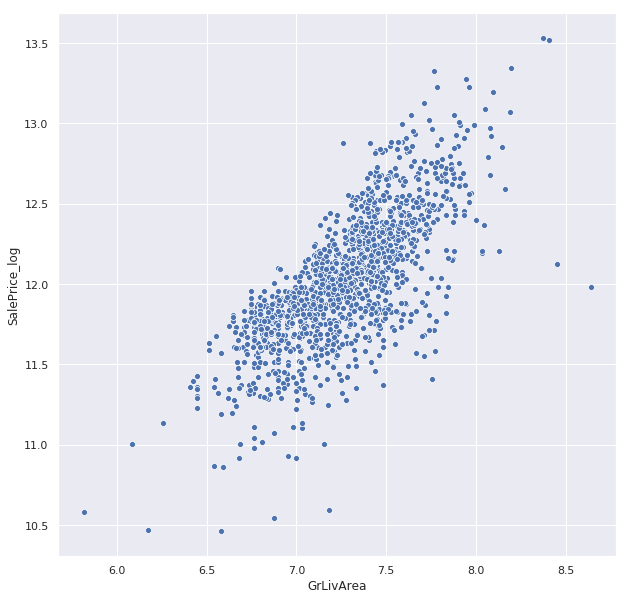

In [72]:
# show relationship between SalePrice and Living Area
plt.subplots(figsize=(10,10))
sns.scatterplot(x=df_train_drop_useless['GrLivArea'],y=df_train_drop_useless['SalePrice_log'])

In [73]:
## drop outliers of data which sale price > 13.5 and living area > 4000
drop_index = df_train_drop_useless[(df_train_drop_useless['SalePrice_log'] > 13.5) | (df_train_drop_useless['GrLivArea'] > 8.3)].index
df_train_drop_outliers = df_train_drop_useless.drop(drop_index)
print(df_train_drop_outliers.shape)

(1456, 75)


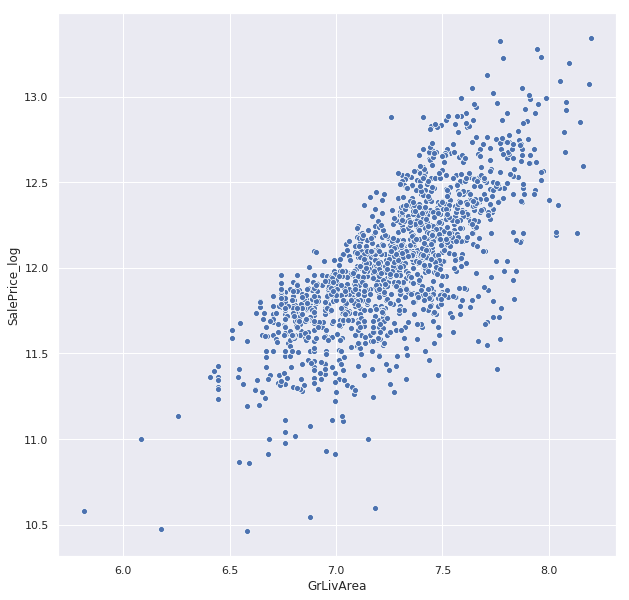

In [74]:
## show relationship between living area and Sale price after droping 
plt.subplots(figsize=(10,10))
sns.scatterplot(x=df_train_drop_outliers['GrLivArea'],y=df_train_drop_outliers['SalePrice_log'],data=df_train)

* Ground living Area vs Sale price group by overall quality<a name="scattergla+">

In [75]:
plotly_scatter_x_y_catg_color(df_train_drop_outliers, 'GrLivArea', 'SalePrice', 'OverallQual')

* Area features VS Sale Price <a name='area'>

In [76]:
y_col_vals = 'SalePrice_log'
area_features = ['TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
                 'MasVnrArea', 'GarageArea', 'LotArea',
                 'WoodDeckSF', 'OpenPorchSF', 'BsmtFinSF1']
                # 'ScreenPorch'
x_col_vals = area_features

In [77]:
nr_rows=3
nr_cols=3

fig = tools.make_subplots(rows=nr_rows, cols=nr_cols, print_grid=False,
                          subplot_titles=area_features )
                                                                
for row in range(1,nr_rows+1):
    for col in range(1,nr_cols+1): 
        
        i = (row-1) * nr_cols + col-1
     
        trace = go.Scatter(x = df_train_drop_useless[x_col_vals[i]], 
                           y = df_train_drop_useless[y_col_vals], 
                           name=x_col_vals[i], 
                           mode="markers", 
                           opacity=0.8)

        fig.append_trace(trace, row, col,)
 
                                                                                                  
fig['layout'].update(height=700, width=900, showlegend=False,
                     title='SalePrice vs. Area features')
iplot(fig)                                                

It shows that all of the Area features are positive related to sale price. In the Pearson correlation coefficient, it shows that Total Basement SF having very strong positive relation with first floor SF and we also obvered that Total Basement SF having strong positive relation with second floor SF. So I think it should have new feature sum all of area features.

In [78]:
df_train_drop_outliers['allarea'] = (df_train_drop_outliers['TotalBsmtSF'] + df_train_drop_outliers['1stFlrSF'] + df_train_drop_outliers['2ndFlrSF'] + df_train_drop_outliers['MasVnrArea']
                                    + df_train_drop_outliers['GarageArea']  + df_train_drop_outliers['WoodDeckSF'] + df_train_drop_outliers['OpenPorchSF']
                                    + df_train_drop_outliers['BsmtFinSF1'].astype(int))

df_test_drop['allarea'] = (df_test_drop['TotalBsmtSF'] + df_test_drop['1stFlrSF'] + df_test_drop['2ndFlrSF'] + df_test_drop['MasVnrArea']+ df_test_drop['GarageArea']
                        + df_test_drop['WoodDeckSF'] + df_test_drop['OpenPorchSF']+ df_test_drop['BsmtFinSF1'].astype(int))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [79]:
print(df_train_drop_outliers['allarea'].corr(df_train_drop_outliers['SalePrice_log']))

0.8373843141078111


* Groud Living Area VS Total rooms above grade<a name= 'glatagscatter'>

In [80]:
plotly_scatter_x_y(df_train_drop_outliers,'GrLivArea','TotRmsAbvGrd')

#### 4.3.3 Understand relationship between some categorical features and house price

* Total Rooms Grade vs Ground Living Area<a name='glatagbox'>

In [96]:
plotly_box_x_y(df_train_drop_outliers,'TotRmsAbvGrd','GrLivArea')

* Garage Car vs Garage Area<a name='garagecar'>

In [97]:
plotly_box_x_y(df_train_drop_useless,'GarageCars','GarageArea')

* Over all quality VS Sale Price log<a name='overall'>

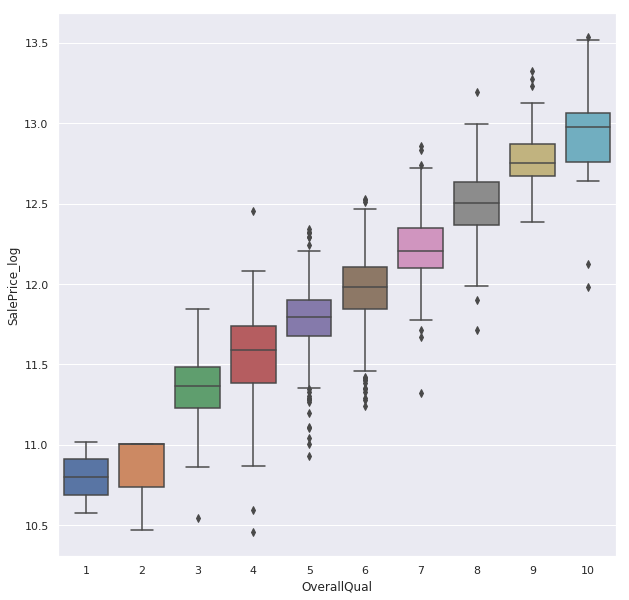

In [83]:
## show relationship between all quality and Sale price
f,ax = plt.subplots(figsize=(10,10))
sns.boxplot(x=df_train_drop_useless['OverallQual'],y=df_train_drop_useless['SalePrice_log'],data=df_train)

* Year Built VS Sale Price<a name='year'>

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111]),
 <a list of 112 Text xticklabel objects>)

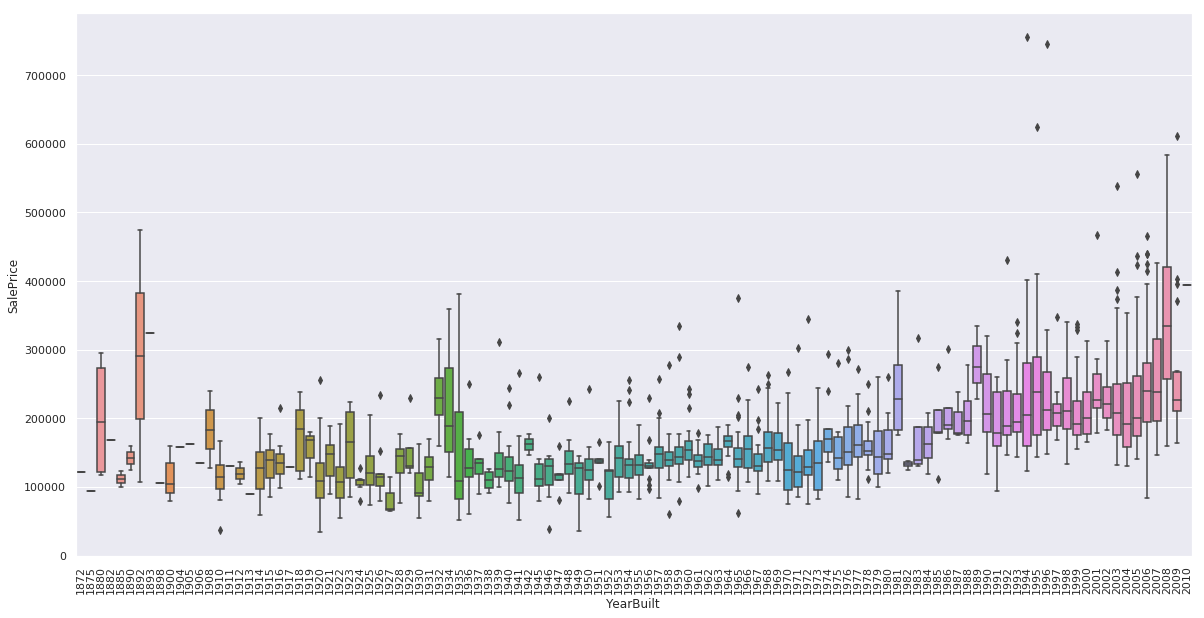

In [84]:
## show relationship between year built of house and sale price
f,ax = plt.subplots(figsize=(20,10))
sns.boxplot(x=df_train_drop_useless['YearBuilt'],y=df_train_drop_useless['SalePrice'])
plt.xticks(rotation='90')

* Year Built VS Sale Price group by house style<a name='yearstyle'>

In [86]:
plotly_scatter_x_y_catg_color(df_train_drop_outliers,'YearBuilt','SalePrice','HouseStyle')

* MS Zooming vs Sale Price<a name='ms'>

In [103]:
plotly_scatter_x_y_catg_color(df_train_drop_outliers,'YearBuilt','SalePrice','Neighborhood')

In [100]:
## show relationship between MS Zooming and sale price
plotly_box_x_y(df_train_drop_outliers,'MSZoning','SalePrice')

* MS SubClass vs Sale Price<a name='msclass'>

In [101]:
plotly_box_x_y(df_train_drop_outliers,'MSSubClass','SalePrice')

* Neighbourhood vs Sale Price<a name='neighbourhood'>

In [102]:
## show relationship between MS Zooming and sale price
plotly_box_x_y(df_train_drop_outliers,'Neighborhood','SalePrice')